# Return on Housing in Budapest
We would like to provide the complete description of the analysis that we have performed in order to compute the realized ex-post return on housing in Budapest. We compute the nominal return on an average flat in Budapest. We make several important assumptions, and we would like to be explicit about them. We provide the code written in Python, so that the interested reader could change the assumptions and re-compute the return according to their preferences.

In [1]:
# First, we need to import all the Python toolboxes necessary for the analysis
import pandas as pd
import math
import numpy as np
import requests
import matplotlib.pyplot as plt

### Data
Aggregated data on rental rates are difficult to come by. We rely on the average rental rates per square meter published by ingatlannet.hu, which also includes the data on rents in Budapest:

Data on rents per sq. m.: extracted from ingatlan.hu: 



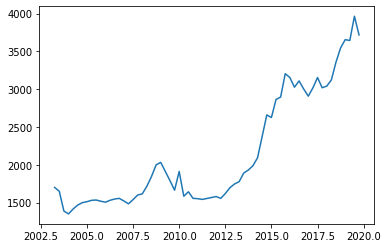

In [2]:
# Download the data on rents per sq.m. from ingatlannet.hu
dls = "https://pic01.ingatlannet.hu/xlsx/statisztika/statisztika_20megye.xlsx"
resp = requests.get(dls)
with open('ingatlannet.xls', 'wb') as output:
    output.write(resp.content)
    
data_rent = pd.read_excel('ingatlannet.xls', sheet_name = 5, header=0, 
                     names=['month', 'rent'], usecols = [0, 1], skiprows = 1)
data_price = pd.read_excel('ingatlannet.xls', sheet_name = 2, header=0, 
                     names=['month', 'price'], usecols = [0, 1], skiprows = 1)

# Construct the vectors of years and quarters for which we have data
y_min = int(data_rent['month'][0][0:4])
y_max = int(data_rent['month'][len(data_rent['month'])-1][0:4])

y = []
q = []
for yy in range(y_min, y_max+1):
    y.extend(list(np.tile(yy,4)))
    q.extend([1,2,3,4])

m_max = int(data_rent['month'][len(data_rent['month'])-1][5:7])
q_max = math.floor(m_max/3)
y = y[0:-(4-q_max)]
q = q[0:-(4-q_max)]
date = np.add(y, [x/4 for x in q])

# Construct the vector of nominal rents
# There are missing values for some of the months, 
# so we use the latest available observation in each quarter
m = [['03','02','01'], ['06','05','04'], ['09','08','07'], ['12','11','10']]
r = []
for i in range(0,len(y)):
    try:
        r_i = list(data_rent['month']).index(str(y[i])+"-"+m[q[i]-1][0])
    except ValueError:
        try:
            r_i = list(data_rent['month']).index(str(y[i])+"-"+m[q[i]-1][1])
        except ValueError:
            try: 
                r_i = list(data_rent['month']).index(str(y[i])+"-"+m[q[i]-1][2])
            except ValueError:
                r_i = 'm'
    if r_i == 'm':
        r.extend(['missing'])
    else:
        r.extend([data_rent['rent'][r_i]])

for i in range(0, r.count('missing')):
    r_i = r.index('missing')
    r[r_i] = r[r_i-1]/2 + r[r_i+1]/2
    
print('\nData on rents per sq. m.: extracted from ingatlan.hu: \n')

plt.plot(date,r)
plt.show()

Also, as a starting point, we use the same source for the per-square-meter price of an average apartment at the end of 2018. For our calculations, we select the size of the apartment to be 50 sq.m. For such apartment, we compute the price and the rental rate at the end of 2018:

In [5]:
t = '2018-12'
sqm = 50

# Extract the data on the price and rent of a flat for the period specified by t and for the size specified by sqm
rent_t = data_rent['rent'][list(data_rent['month']).index(t)] / 1000 * sqm
price_t = data_price['price'][list(data_price['month']).index(t)] / 1000 * sqm

print('\nAccording to ingatlannet.hu, in '+t+', for an average '+str(sqm)+'-sq.m. apartment in Budapest,')
print('\t - the price is '+str(price_t)+' thousand forints, and')
print('\t - the rent is '+str(rent_t)+' thousand forints per month')


According to ingatlannet.hu, in 2018-12, for an average 50-sq.m. apartment in Budapest,
	 - the price is 36955.55 thousand forints, and
	 - the rent is 182.75 thousand forints per month


As for the data on price dynamics, we consider MNB House Price Index to be the most reliable source. Using the average price at the end of 2018 extracted from ingatlannet.hu as our nominal anchor, we will be tracing the evolution of the price using the MNB data.



Nominal price index (2001q1 = 100) extracted from mnb.hu: 



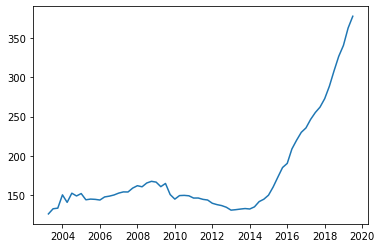

In [6]:
# Download the data on price dynamics from MNB
dls = "https://www.mnb.hu/letoltes/mnb-lakasarindex.xlsx"
resp = requests.get(dls)
with open('mnb.xls', 'wb') as output:
    output.write(resp.content)
    
data_price = pd.read_excel('mnb.xls', sheet_name = 1, header=0, 
                     names=['quarter', 'price'], usecols = [1, 3], skiprows = 3)
s = list(data_price['quarter']).index('2003. I.')
n = list([str(e) for e in list(data_price['quarter'])]).index('nan')
p = list(data_price['price'][s:n])

print('\n\nNominal price index (2001q1 = 100) extracted from mnb.hu: \n')
fig2, ax2 = plt.subplots()
ax2.plot(date[0:len(p)],p)
plt.show()

Finally, we combine the data from the two sources.

In [8]:
# Combine the data on rents and prices from the two sources:
r_apt = []
p_apt = []
ref = (int(t[0:4])-2003)*4 + math.floor(int(t[5:7])/3 - 1)
for i in range(0,len(p)):
    r_apt.extend([r[i]/r[ref] * rent_t])
    p_apt.extend([p[i] / p[ref] * price_t])

y = y[0:len(p)]
q = q[0:len(p)]
date = date[0:len(p)]

### Residential Investment - Structure of the Project
The next thing to think about is the structure of the residential investment project that we are going to consider. We make the following assumptions:
* We assume a five-year project. That is, the apartment is purchased, rented out, and then sold after five years. This is a rather short project, considering how illiquid the real-estate market is and how few transactions an average person makes in this market during their lifetime. However, this horizon is definitely feasible. Moreover, one could think, for example, about a 10-year investment as a combination of two back-to-back investment projects. The benefit of considering five years is that that this way, we make housing investment comparable with investment into 5-year government bonds, which are very popular today. Also, 5-year horizon implies that there are no capital-gain taxes in case of both housing and bond investment.
* We assume that the stamp duty equal to 4% has to be paid upon the purchase. The underlying assumption is that the apartment is bought on the market to be rented out to a third party, and that there were no additional property trades within one year before and after the purchase (which would complicated the analysis tremendously).
* We assume that the owner signs a one-year rental contract with the tenant with a fixed rental rate, and then the rental rate is increased after every year in order to catch up with the market rate. This is in line with the common practice that the rental rate is re-negotiated once a year.